# Imports

In [21]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


# Transformaciones

In [22]:
# Definir transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((950, 450)),  # Resize the images
    transforms.RandomHorizontalFlip(p=0.5),  # Apply horizontal flip with a 50% chance
    # transforms.RandomVerticalFlip(p=0.5),    # Apply vertical flip with a 50% chance (optional)
    transforms.RandomRotation(degrees=30),   # Randomly rotate the image by up to 30 degrees
    # minimun size of the image
    transforms.ToTensor(),                   # Convert image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize the values
])

# Extracción

In [23]:
# Cargar los conjuntos de datos desde las carpetas separadas
train_dataset = ImageFolder(root='dataset_split\\train', transform=transform)
validation_dataset = ImageFolder(root='dataset_split\\validation', transform=transform)
test_dataset = ImageFolder(root='dataset_split\\test', transform=transform)


# Verifica que las clases están correctamente identificadas
print(f"Clases encontradas: {train_dataset.classes}")

Clases encontradas: ['cama_vacia', 'vaca_acostada', 'vaca_de_pie']


# Dataloaders

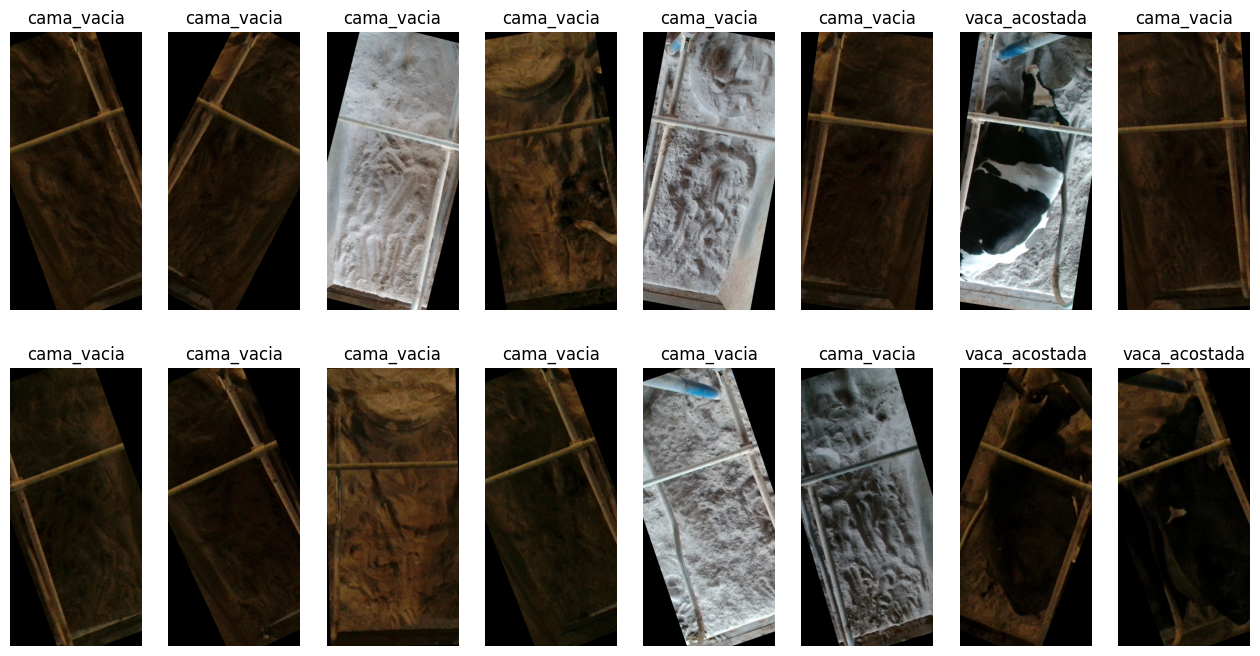

In [24]:
# Mostrar imagenes de ejemplo
import matplotlib.pyplot as plt
import numpy as np

# Definir una función para mostrar imágenes
def show_images(dataset, n_images):
    # Crear un DataLoader con el conjunto de datos
    loader = DataLoader(dataset, batch_size=n_images, shuffle=True)
    # Obtener un lote de imágenes
    images, labels = next(iter(loader))
    # Mostrar las imágenes en una cuadrícula
    plt.figure(figsize=(16, 8))
    images = images / 2 + 0.5
    npimg = images.numpy()
    
    # Display each image in a grid
    for i in range(n_images):
        plt.subplot(2, n_images // 2, i + 1)
        plt.imshow(np.transpose(npimg[i], (1, 2, 0)))
        plt.axis('off')
        plt.title(dataset.classes[labels[i]])

show_images(train_dataset, 16)

In [25]:
# Crear los DataLoader para cada conjunto de datos
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Modelo

In [36]:
# Modificar la clase SimpleCNN para que coincida con la arquitectura del modelo guardado
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), # 3 canales de entrada, 16 filtros de 3x3
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 225 * 475, 32), 
            nn.ReLU(),

            nn.Linear(32, 64),
            nn.ReLU(),

            nn.Linear(64, 128),
            nn.ReLU(),

            nn.Linear(128, 3),  # 3 clases: vaca_de_pie, vaca_acostada, cama_vacia
            # nn.Softmax(dim=1) # Softmax para clasificación multiclase
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

In [37]:
# Inicializar el modelo, criterio (loss) y optimizador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()  # Para clasificación multiclase
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento

In [38]:
# Entrenar con Gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'Usando el dispositivo: {device}')

Usando el dispositivo: cuda


In [ ]:
# Hiperparámetros
num_epochs = 25

# Entrenamiento del modelo
for epoch in range(num_epochs):
    model.train()  # Modo de entrenamiento
    running_loss = 0.0

    # Usar tqdm para la barra de progreso
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch'):
        images, labels = images.to(device), labels.to(device)  # Move to the same device
        optimizer.zero_grad()  # Resetear gradientes
        outputs = model(images)  # Forward
        loss = criterion(outputs, labels)  # Calcular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos

        running_loss += loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}')

    # Evaluación en el conjunto de validación
    model.eval()  # Modo de evaluación
    correct = 0
    total = 0

    with torch.no_grad():  # No se calculan gradientes en evaluación
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)  # Move to the same device
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)  # Predicción
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_accuracy = 100 * correct / total
    print(f'Validation Accuracy: {validation_accuracy}%')
    
        # Guardar el modelo cada 3 epochs
    if (epoch + 1) % 3 == 0:
        torch.save(model.state_dict(), f'Modelos/model_epoch_{epoch+1}.pth')
        print(f'Model saved at epoch {epoch+1}')


# Evaluación de entrenamiento

In [39]:

model.load_state_dict(torch.load('Modelos/model_epoch_19.pth'))

C:\Users\Tony\AppData\Local\Temp\ipykernel_6024\1869969349.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('Modelos/model_epoch_19.pth')

<All keys matched successfully>

In [40]:
# Evaluación final en el conjunto de prueba
model.eval()  # Modo de evaluación
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to the same device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')

Test Accuracy: 97.91783905458638%


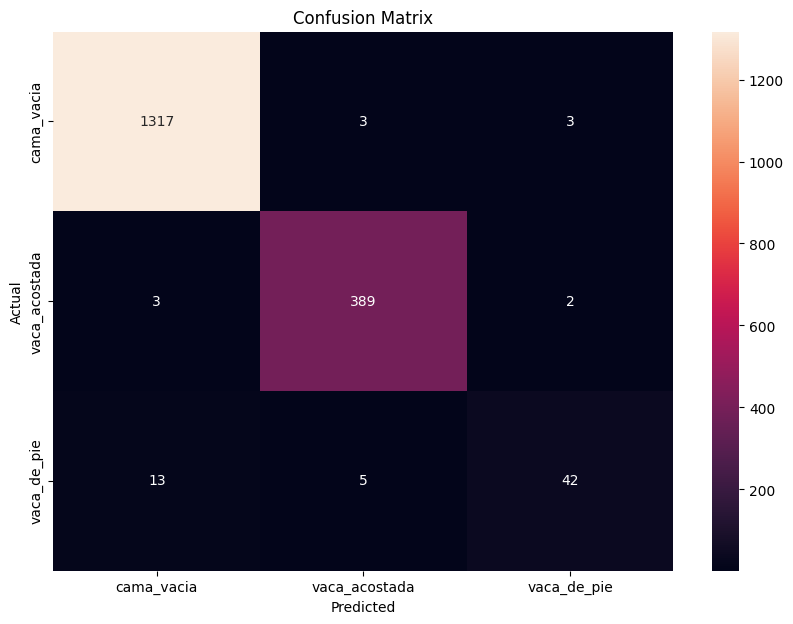

In [41]:
# make a cofusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model.eval()  # Modo de evaluación
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to the same device
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


ValueError: num must be an integer with 1 <= num <= 25, not 26

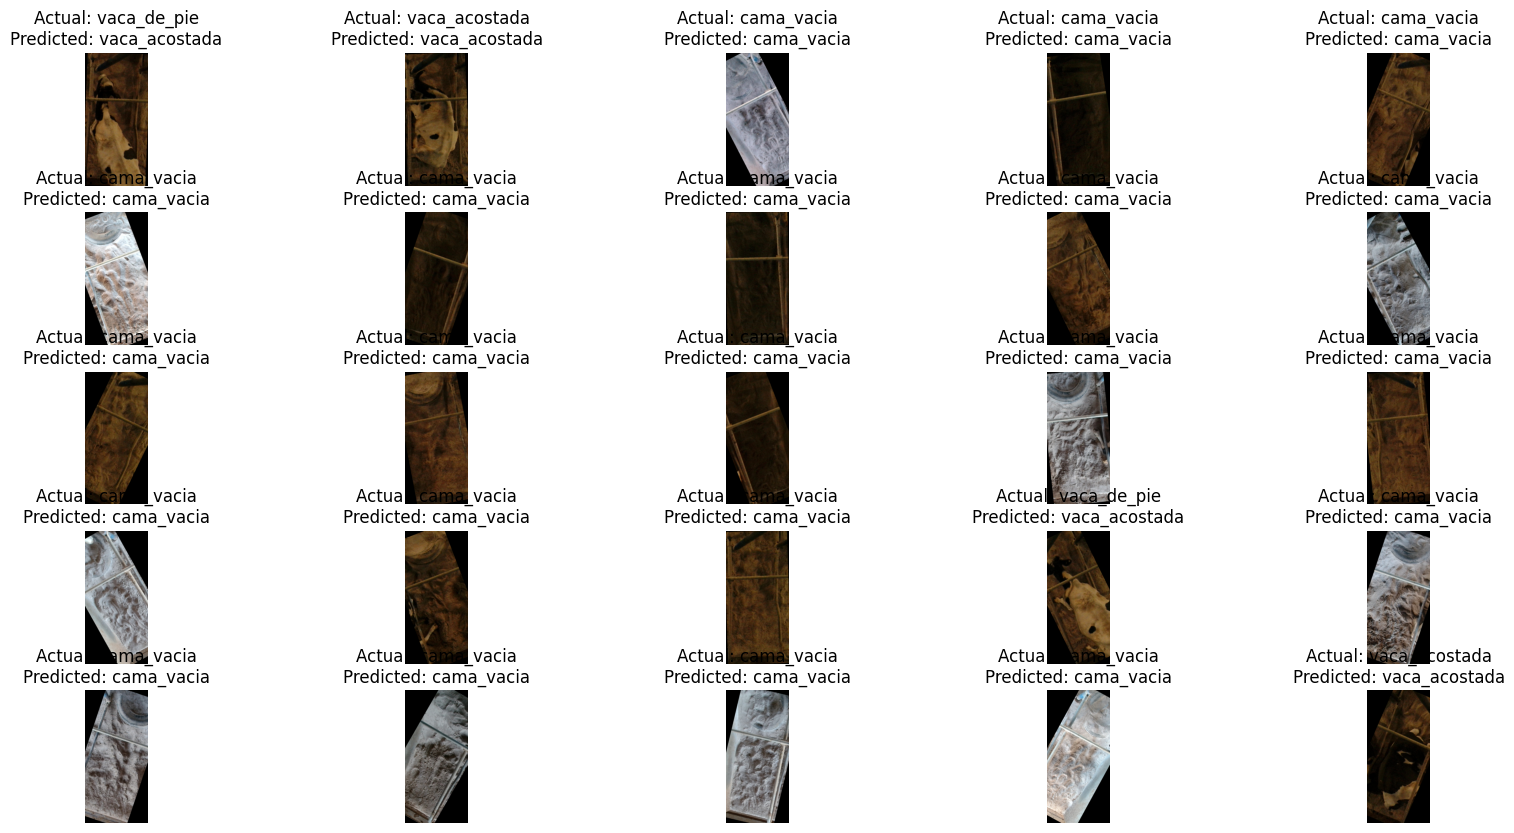

In [53]:
# show some images and their predictions
import matplotlib.pyplot as plt
import numpy as np

model.eval()  # Modo de evaluación

# Create a DataLoader with the test dataset
loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
# Get a batch of test images and labels
images, labels = next(iter(loader))
images, labels = images.to(device), labels.to(device)  # Move to the same device

# Make predictions
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Display the images, labels, and model's predictions
plt.figure(figsize=(20, 10))
for i in range(len(images)):  # Ensure the loop iterates only over the number of images in the batch
    plt.subplot(5, 5, i + 1)
    image = images[i] / 2 + 0.5  # Unnormalize
    image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Actual: {train_dataset.classes[labels[i]]}\nPredicted: {train_dataset.classes[predicted[i]]}')
plt.show()

# Filter images of the selected class 'vaca_de_pie'
selected_class = 'vaca_de_pie'
selected_indices = [i for i, label in enumerate(labels) if train_dataset.classes[label] == selected_class]

plt.figure(figsize=(20, 10))
for i, idx in enumerate(selected_indices[:25]):  # Limit to 25 images
    plt.subplot(5, 5, i + 1)
    image = images[idx] / 2 + 0.5  # Unnormalize
    image = image.cpu().numpy()
    plt.imshow(np.transpose(image, (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Actual: {train_dataset.classes[labels[idx]]}\nPredicted: {train_dataset.classes[predicted[idx]]}')
plt.show()
